In [55]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["image.cmap"] = "gray"

In [68]:
# Physical parameters
wavelength = 193   # 193 nm
NA = 1.35             # NA

In [70]:
# Simulation grid
N = 512          # grid size
L = 2000         # 2000nm simulation window

x = np.linspace(-L/2, L/2, N)
y = np.linspace(-L/2, L/2, N)
X, Y = np.meshgrid(x, y)

dx = x[1] - x[0]
print(dx)

3.9138943248532314


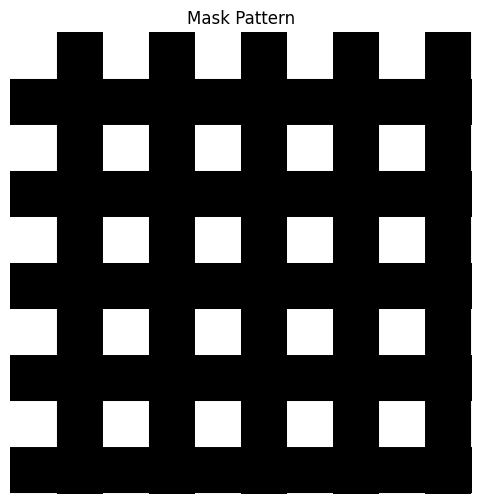

In [71]:
# Mask definition
CD = 200    # Hole/Line size (200 nm)
Pitch = 400 # 400 nm pitch

# lines or contact
pattern_type = "contact" 

mask = np.zeros((N, N))

if pattern_type == "lines": #Grating L/S
    mask[((X + Pitch/2) % Pitch) < CD] = 1.0
elif pattern_type == "contact":
    # 2D contacts (Intersection of X and Y gratings)
    # We define a hole where BOTH X and Y satisfy the condition
    condition_x = ((X + Pitch/2) % Pitch) < CD
    condition_y = ((Y + Pitch/2) % Pitch) < CD
    mask[condition_x & condition_y] = 1.0
plt.imshow(mask)
plt.title("Mask Pattern")
plt.axis("off")
plt.show()


In [72]:
# Spatial frequency coordinates
fx = np.fft.fftfreq(N, d=dx)
fy = np.fft.fftfreq(N, d=dx)

FX, FY = np.meshgrid(fx, fy)
print(FX,FY)

[[ 0.          0.00049902  0.00099805 ... -0.00149707 -0.00099805
  -0.00049902]
 [ 0.          0.00049902  0.00099805 ... -0.00149707 -0.00099805
  -0.00049902]
 [ 0.          0.00049902  0.00099805 ... -0.00149707 -0.00099805
  -0.00049902]
 ...
 [ 0.          0.00049902  0.00099805 ... -0.00149707 -0.00099805
  -0.00049902]
 [ 0.          0.00049902  0.00099805 ... -0.00149707 -0.00099805
  -0.00049902]
 [ 0.          0.00049902  0.00099805 ... -0.00149707 -0.00099805
  -0.00049902]] [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.00049902  0.00049902  0.00049902 ...  0.00049902  0.00049902
   0.00049902]
 [ 0.00099805  0.00099805  0.00099805 ...  0.00099805  0.00099805
   0.00099805]
 ...
 [-0.00149707 -0.00149707 -0.00149707 ... -0.00149707 -0.00149707
  -0.00149707]
 [-0.00099805 -0.00099805 -0.00099805 ... -0.00099805 -0.00099805
  -0.00099805]
 [-0.00049902 -0.00049902 -0.00049902 ... -0.00049902 -0.00049902
  -0.00049902]]


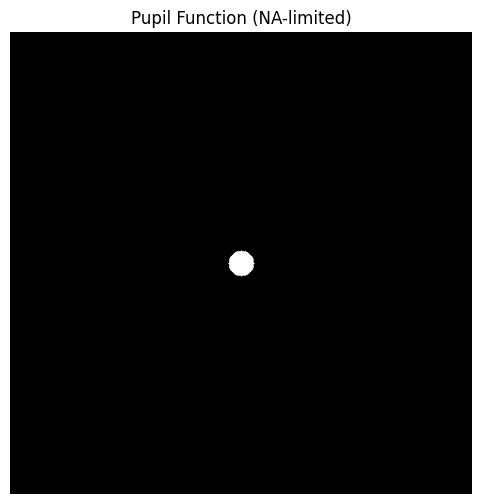

In [73]:
# Pupil function

freq_radius = np.sqrt(FX**2 + FY**2)
f_cutoff = NA/wavelength 

pupil = np.zeros_like(freq_radius)
pupil[freq_radius <= f_cutoff] = 1.0

plt.imshow(np.fft.fftshift(pupil))
plt.title("Pupil Function (NA-limited)")
plt.axis("off")
plt.show()


In [74]:
# Forward optical propagation
mask_fft = np.fft.fft2(mask)
filtered_fft = mask_fft * pupil
field = np.fft.ifft2(filtered_fft)


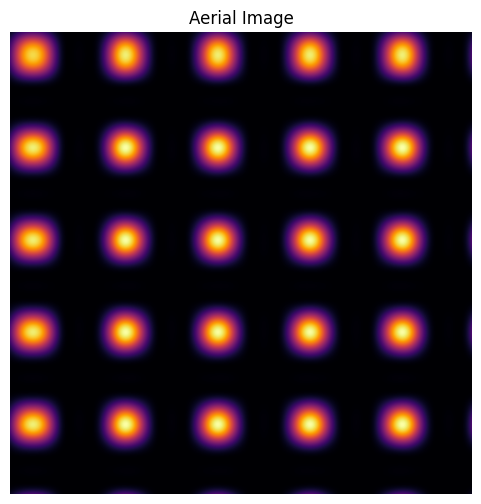

In [75]:
# Aerial image
intensity = np.abs(field)**2
intensity /= intensity.max()

plt.imshow(intensity, cmap="inferno")
plt.title("Aerial Image")
plt.axis("off")
plt.show()


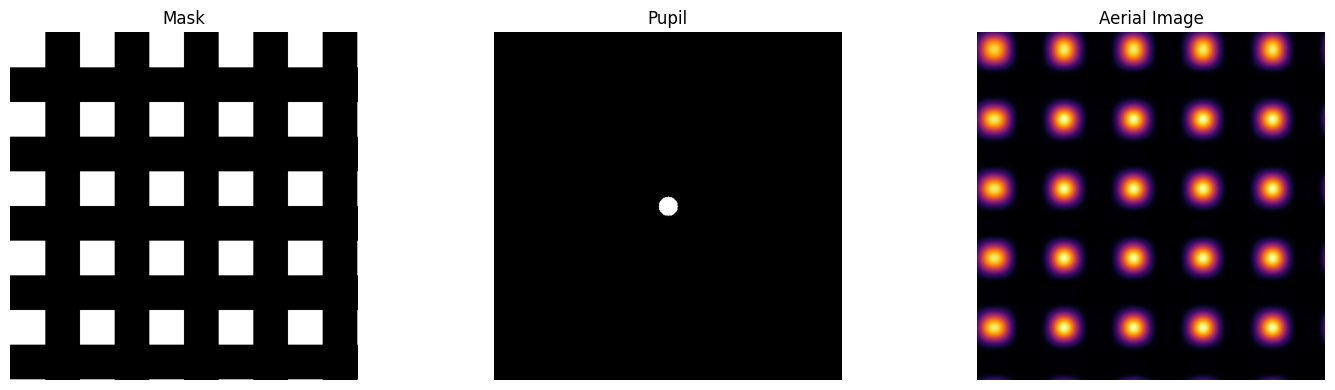

In [76]:
#sanity check
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].imshow(mask)
ax[0].set_title("Mask")
ax[0].axis("off")

ax[1].imshow(np.fft.fftshift(pupil), extent=[np.min(fx), np.max(fx), np.min(fy), np.max(fy)])
ax[1].set_title("Pupil")
ax[1].axis("off")


ax[2].imshow(intensity, cmap="inferno")
ax[2].set_title("Aerial Image")
ax[2].axis("off")

plt.tight_layout()
plt.show()


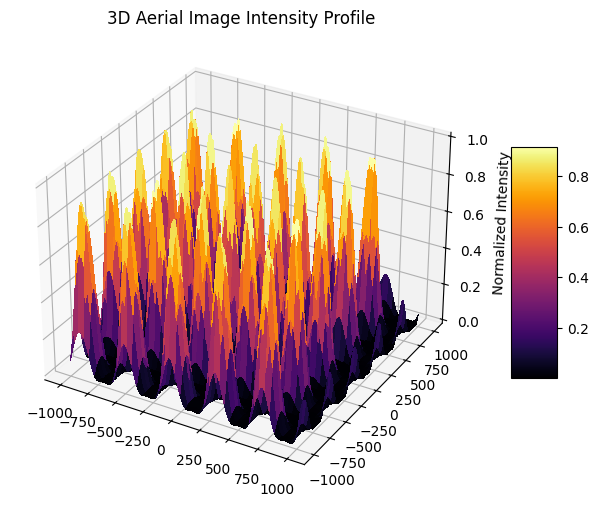

In [77]:
#3d aerial image
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(X, Y, intensity, cmap="inferno", linewidth=0, antialiased=False)

ax.set_title("3D Aerial Image Intensity Profile")
ax.set_zlabel("Normalized Intensity")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

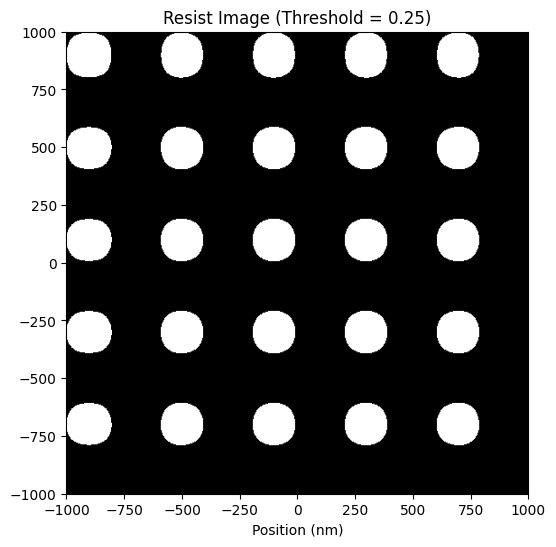

In [84]:
#resist image
resist_threshold = 0.25

resist_img = np.zeros_like(intensity)
resist_img[intensity >= resist_threshold] = 1.0

plt.figure(figsize=(6, 6))
plt.imshow(resist_img, cmap="gray", extent=[-L/2, L/2, -L/2, L/2])
plt.title(f"Resist Image (Threshold = {resist_threshold})")
plt.xlabel("Position (nm)")
plt.show()